In [5]:
#Note: GLM, DataFrames and Statistics are only needed towards the very end of this notebook.
#LinearAlgebra is used to provide basic operations and check correctness of algorithms
#Distributions is used to create random matrices
#BenchmarkTools is used to measure computation efficiency
#Plots is used to plot results
#LaTeXStrings is used to add Latex to plot and axis titles
#GLM, DataFrames and Statistics are used for some statistical analysis towards the end
#(such as standard deviation, lines of best fit, etc...)
using LinearAlgebra, Distributions, BenchmarkTools, Plots, LaTeXStrings, GLM, DataFrames, Statistics

In [6]:
"""
Takes input n and m and creates n×n matrix with m non-zero elements randomly selected to be floats between -1 and 1
"""
function randmatrix(n::Int64, m::Int64)
    p = Float64(m)/Float64(n)^2 #Calculates success rate
    M = rand(Bernoulli(p), n, n) #Creates n×n bernoulli matrix (0 and 1s)
    N = rand(Uniform(-1,1), n, n) #Creates n×n matrix with values random between -1 and 1
    for i = 1:n
        for j = 1:n
            if M[i,j] == 0
                N[i,j] = 0.0 #If value in M is 0, corresponding value in N is changed to 0.0, otherwise, do nothing
            end
        end
    end
    return N
end

randmatrix

In [7]:
"####################

QR ALGORITHM

####################"


"""
Given a real square matrix M and an integer m, outputs householder reflection for the mth column
"""
function house(M::Matrix, m::Int64, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:m
        A = A[1:n-i+1 .!= 1,: ] #Removes first m rows
    end
    a = A[:,m] #Extracts mth column (with only n-m elements now)
    e = I[1:(n-m), 1] #Creates vector with n-m elements, leading with 1 and all other elements 0
    w = a - norm(a)*e #Calculates w
    if norm(w) > ϵ
        P = Float64.(Matrix(I, n-m, n-m)) - (2w*(w'))/(norm(w)^2) #Calculates householder matrix P
    else
        P = Float64.(Matrix(I, n-m, n-m))
    end
    U = Float64.(Matrix(I, n, n)) #Initialises identity matrix
    for i = 1:n-m
        for j = 1:n-m
            U[i+m,j+m] = P[i,j] #Extends P to n×n dimensions by inserting P into the bottom right corner of an identity matrix
        end
    end
    return U #Returns householder transformation U
end
     


"""
Calculates similar hessenberg matrix of a given real square matrix M
"""
function hessen(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M) #Initialises copy of M
    for i = 1:n-2
        U = house(A, i, n, ϵ) #Recursively generates householder transformation
        A = U*A*(U') #Applies transformation to A (uses conjugate transpose to retain similarity)
    end
    return A #Returns hessenberg matrix A
end 
     


"""
Computes Givens Rotation that shifts 2×2 matrix with left column [a b] in to an upper-triangular matrix (bottom left 0)
"""
function given(a::ComplexF64, b::ComplexF64, ϵ::Float64) #ϵ is the error
    u = (abs2(a) + abs2(b))^0.5 #Calculates norm of vector [a b]
    if u > ϵ
        c = a/u #Calculates c
        s = b/u #Calculates s
        G = [conj(c) conj(s); -s c] #Calculates Givens Rotation G
        return G #Returns G
    else
        return [1 0; 0 1]
    end
end
     


"""
Calculates QR form of a real square matrix using Hessenberg reduction and Givens Rotations
"""
function hessenqrdecomp(M::Matrix, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    A = copy(M)
    T = Matrix(I, n, n) #Initialises product of Givens Rotations
    for i = 1:n-1 #As Givens rotations are 2×2 matrixs, we only need to do n-1, not n, iterations
        a = A[i,i] #Extract arguements for given() function
        b = A[i+1,i]
        G = given(a, b, ϵ) #Creates Givens Rotation
        F = ComplexF64.(Matrix(I, n, n)) #Initialises n×n identity matrix
        F[i,i], F[i,i+1], F[i+1,i], F[i+1,i+1] = G[1,1], G[1,2], G[2,1], G[2,2] #Inserts Givens Rotation along the diagonal
        T = F*T #Updates product of Givens Rotations
        A = F*A #Applies Givens Rotation to A
    end
    R = A #Calculates R
    Q = T' #Calculates Q 
    return Q, R #Return QR form
end
     


"""
Given a Complex square matrix M computes one step of the Francis Double Shift modification for the QR algorithm
The Algorithm checks bottom left 2×2 submatrix of M.
This matrix will have real eigenvalues is the bottom left entry is zero, and complex otherwise.
"""
function francisqrdecomp(M::Matrix{ComplexF64}, n::Int64, ϵ::Float64) #n is dimensions of matrix, ϵ the error
    if abs(M[n,n-1]) < ϵ #checks if bottom left entry of submatrix is 0, meaning we have real eigenvalues
        μ = min(M[n-1,n-1].re, M[n,n].re) #Extracts smaller of the two eigenvalues
        T = M - μ*I #Performs shift
        Q, R = hessenqrdecomp(T,n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ*I #Corrects shift
    else #In this case, the eigenvalues are complex
        a, b, c, d = M[n-1,n-1], M[n-1,n], M[n,n-1], M[n,n] #Extracts entries of 2×w matrix
        μ1 = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates both eigenvalues analytically
        μ2 = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2
        T = M - μ1*I #Performs shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ1*I #Corrects shift
        T = M - μ2*I #Performs second shift
        Q, R = hessenqrdecomp(T, n, ϵ) #Performs hessenberg decomposition
        M = R*Q + μ2*I #Corrects second shift
    end
    return M #Returns modified matrix
end
     


"""
Extracts Eigenvalues from a n×n square matrix in Shur form (derived from real matrix).
Eigenvalues are either on the leading diagonal, or are solved analytically from a 2×w matrix in the case they are complex 
conjugates.
We can check if the eigenvalue on the diagonal is part of such a pair by checking if there is a non-zero element 
below the diagonal
"""
function extracteigen(M::Matrix, n::Int64, ϵ::Float64) #n is the dimensions of matrix, ϵ is error tolerance
    Eigen = zeros(Complex{Float64}, n) #Initialises vector of n eigenvalues
    M = ComplexF64.(M) #Converts matrix into complex form
    for i = 1:n #Recursively checks over all the leading diagonal
        Eigen[i] = M[i,i] #By defualt, the Eigenvalue is taken from the diagonal
        if i < n #Check to prevent index M[i+1,i] from exceeding bounds of n×n matrix
            if abs(M[i+1,i]) > ϵ #Checks if value immediately below the ith diagonal element is non-zero 
                a, b, c, d = M[i,i], M[i,i+1], M[i+1,i], M[i+1,i+1] #Extracts values of 2×2 matrix
                λ = (a + d + ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue. This one takes the positive imaginary
                                                               #solution, we can see below that this eigenvalue pair will be
                                                               #picked up again by i+1, in which case will assign the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
        if i > 1 #Similar check as above, prevents M[i,i-1] from exceeding bounds of n×n matrix
            if abs(M[i,i-1]) > ϵ #Checks if value immediately to the left of the ith diagonal element is non-zero
                                 #Note that this element is still below the diagonal
                a, b, c, d = M[i-1,i-1], M[i-1,i], M[i,i-1], M[i,i] #Extracts values of 2×2 matrix
                λ = (a + d - ((a + d)^2 -4*(a*d - b*c))^0.5)/2 #Calculates eigenvalue, As the positive imaginary solution was
                                                               #picked on the previous iteration, we take the negative
                                                               #imaginary solution
                Eigen[i] = λ #Assigns Eigenvalue as being λ
            end
        end
    end
    return Eigen #Returns list of Eigenvalues
end
     


"""
Given a real square matrix M, calculates eigenvalues uses QR algorith.
Uses Hessenberg Decomposition and Francis Double Shifts for increased efficiency
"""
function hessfrancisqralg(M::Matrix{Float64})
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    A = hessen(M, n, ϵ1) #Reduces matrix to hessenberg form
    newA = francisqrdecomp(A, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(A, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end

hessfrancisqralg

In [8]:
"###############

ARNOLDI ALGORITHM

###############"


"""
Produces a randomised and normalised vector of length n
"""
function normalizedrandomvector(n,k)
    b = zeros(n,k)
    b[:,1] = rand(n)
    b[:,1] /= norm(b[:,1])
    return b
end

"""
Given a matrix A, int k, and random vector b, prodcues uses k arnoldi iterations to reduce to hessenberg form.
"""
function arnoldihessenberg(A,b,k)
    #Initializing Matrices
    H = zeros(k, k)
    r = copy(b[:,1])
    b[:,1] = r / norm(r)
    # Arnoldi Iteration Process
    for j = 1:k
        if j > 1
            b[:,j] = r / H[j,j-1]
        end
        r = A * b[:,j] 
        # Performing Modified Gram Schmidt
        for i=1:j
            H[i,j] = dot(b[:,i], r)
            r -= H[i,j] * b[:,i]
        end

        if j<k
            H[j+1,j] = norm(r)
        end
    end
    return H
end

"""
Change the size of the arnoldi block in the second line of arnhessfrancisqralg function
This function outputs all eigenvalues by default
"""
function arnhessfrancisqralg(M::Matrix{Float64}) #Hessfrancis using arnoldi
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    k=n #The arnoldi block, set to n elements
    b = normalizedrandomvector(n,k) #normalised random vector for arnoldi hessenberg
    M = arnoldihessenberg(M,b,k)  #Perform arnoldihessenberg
    
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    newM = francisqrdecomp(M, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(M, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newM, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        M = newM #Updates A
        newM = francisqrdecomp(M, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newM, n, ϵ1) #Updates list of eigenvalues of newA
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end

arnhessfrancisqralg

In [9]:
"#################

VERIFIES CORRECTNESS OF QR ALGORITHM, WITH EXAMPLES

#################"

"""
Finds average difference bewteen eigenvalues from QR algorithm and inbuilt eigvals function.
Used to demonstrate accurcay of QR algorithm.
"""
function avediffeigqr(M::Matrix{Float64})
    ϵ = 1e-5
    eig = eigvals(M) #Extracts eigvals
    n = size(eig,1) #Gets number of eigenvalues
    #The following sorts QR eigenvalues first by real component, then by imaginary (same as in eigvals)
    sortqr = sort(hessfrancisqralg(M), lt = (x,y) -> real(x)==real(y) ? imag(x)<imag(y) : real(x)<real(y)) 
    for i = 2:n #Sometimes, the above may get the order of complex conjugates incorrect due to machine error
        if (abs(sortqr[i].re - sortqr[i-1].re) < 1e-5) & (sortqr[i].im < sortqr[i-1].im) #This corrects that
            sortqr[i], sortqr[i-1] = sortqr[i-1], sortqr[i] #Reorders if needed
        end
    end
    sum = 0 #Initialises sum
    for i = 1:n
        sum += abs(sortqr[i] - eig[i]) #Takes magnitude of difference between QR algorithm eigenvalue and eigvals.
                                       #Adds to sum
    end
    ave = sum/n #Averages sum across number of eigenvalues
    return ave #Returns average
end

##### EXAMPLES #####
a = randmatrix(5,25) #Geneterates 5×5 matrix
b = randmatrix(15,225) #Geneterates 15×15 matrix
c = randmatrix(30, 900) #Geneterates 30×30 matrix

print(avediffeigqr(a)," ") #Outputs average difference
print(avediffeigqr(b)," ")
print(avediffeigqr(c))

hessfrancisqralg(c) #Outputs eigenvalues of 30×30 matrix as example

1.6676069328176651e-6 5.756111271466916e-7 1.622090061797002e-7

30-element Vector{ComplexF64}:
   1.3330284558332892 - 2.9786735300120437im
   1.3330284558332874 + 2.978673530012034im
   2.5859125961237903 + 0.0im
  0.10382801502164173 - 2.731226484501438im
  0.10382791497666967 + 2.7312258359215247im
   -2.845573883214619 + 0.531163209413235im
   -2.845573883994414 - 0.5311632094013232im
   1.8706904171860734 - 1.7610905491422997im
   1.8706903285117709 + 1.7610906263656319im
  -1.5085479101401063 + 2.324623593733878im
  -1.5085480021058653 - 2.32462367095723im
  -2.0247603285813582 - 1.7202833911112319im
   -2.024760328581359 + 1.7202833911112314im
                      ⋮
   1.8033898184317347 + 0.9520997986011208im
    1.803389818431728 - 0.9520997986011148im
 -0.40756297307517625 - 1.7479032247600244im
  -0.4075629730751788 + 1.7479032247600537im
   1.5871942692901713 + 0.0im
   1.4730237377105828 + 0.0im
  -0.9811389584372892 + 1.3235703479744008im
  -0.9811389584372952 - 1.3235703479743972im
  -1.0409824176006848 + 0.0im
  0.06178005635585168

In [11]:
"#################

VERIFIES CORRECTNESS OF ARNOLDI QR ALGORITHM, WITH EXAMPLES

#################"

"""
Finds average difference bewteen eigenvalues from Arnodi QR algorithm and inbuilt eigvals function.
Used to demonstrate accurcay of Arnoldi QR algorithm.
"""
function avediffeigarnoldi(M::Matrix{Float64})
    ϵ = 1e-5
    eig = eigvals(M) #Extracts eigvals
    n = size(eig,1) #Gets number of eigenvalues
    #The following sorts Arnoldi QR eigenvalues first by real component, then by imaginary (same as in eigvals)
    sortqr = sort(arnhessfrancisqralg(M), lt = (x,y) -> real(x)==real(y) ? imag(x)<imag(y) : real(x)<real(y)) 
    for i = 2:n #Sometimes, the above may get the order of complex conjugates incorrect due to machine error
        if (abs(sortqr[i].re - sortqr[i-1].re) < 1e-5) & (sortqr[i].im < sortqr[i-1].im) #This corrects that
            sortqr[i], sortqr[i-1] = sortqr[i-1], sortqr[i] #Reorders if needed
        end
    end
    sum = 0 #Initialises sum
    for i = 1:n
        sum += abs(sortqr[i] - eig[i]) #Takes magnitude of difference between QR algorithm eigenvalue and eigvals.
                                       #Adds to sum
    end
    ave = sum/n #Averages sum across number of eigenvalues
    return ave #Returns average
end

##### EXAMPLES #####
a = randmatrix(5,25) #Geneterates 5×5 matrix
b = randmatrix(15,225) #Geneterates 15×15 matrix
c = randmatrix(30, 900) #Geneterates 30×30 matrix

print(avediffeigarnoldi(a)," ") #Outputs average difference
print(avediffeigarnoldi(b)," ")
print(avediffeigarnoldi(c))

arnhessfrancisqralg(c) #Outputs eigenvalues of 30×30 matrix as example

3.2590957405108e-6 3.427513133091924e-7 6.25143951179054e-7

30-element Vector{ComplexF64}:
   2.4257182621500677 + 2.1194552353062646im
   2.4257182621500615 - 2.119455235306261im
   2.7444509722802435 + 0.5541433815947349im
   2.7444509722802417 - 0.5541433815947351im
  -3.2821470597202094 - 1.695579627654475im
   -3.282147059720212 + 1.695579627654476im
    1.614039766075167 + 1.1783465426291195im
   1.6140397660751618 - 1.1783465426291178im
   0.5199706498138268 + 2.210058922119246im
   0.5199706498138148 - 2.210058922119237im
  -0.1898535520157408 + 2.239559547805227im
 -0.18985355201574108 - 2.2395595478052197im
   1.2502398050809784 + 0.5643006877485387im
                      ⋮
   -1.370866351686002 + 1.6939386626347994im
   -1.370866744515871 - 1.6939383639244456im
   0.7278121988553996 + 0.0im
  -2.4809030320863186 + 0.47067987583162185im
   -2.480903128954424 - 0.47067943391527745im
  0.23322557876180772 - 0.8331363401810387im
  0.23322557876176508 + 0.8331363401810793im
    -1.53715556521805 + 0.59933458268572im
  -1.5371555652180553

Processing 2x2Processing 3x3Processing 4x4Processing 5x5Processing 6x6Processing 7x7Processing 8x8Processing 9x9Processing 10x10Processing 11x11Processing 12x12Processing 13x13Processing 14x14Processing 15x15Processing 16x16Processing 17x17Processing 18x18Processing 19x19Processing 20x20

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/du2dt/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194


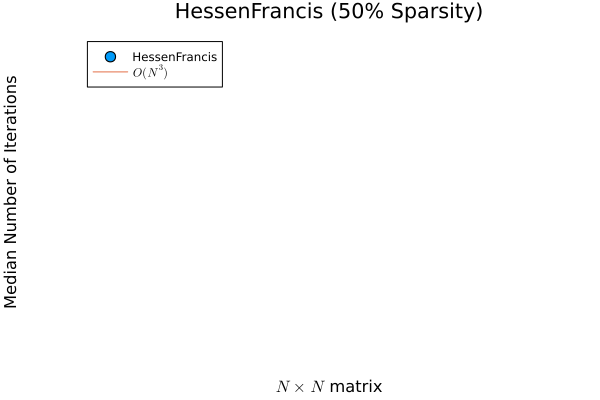

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/du2dt/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/du2dt/src/utils.jl:106


In [22]:
"##############

WARNING: TAKES AROUND 6 MINUTES TO RUN IN CURRENT SETUP
PLOTS THE NUMBER OF ITERATIONS THE QR ALGORITHM TAKES TO TERMINATE
IN CURRENT SETUP: RUNS UP TO 32×32 MATRICES WITH 50% SPARSITY
CAN EASILY BE MODIFIED TO TEST DIFFERENT ARRANGEMENTS (AS SEEN IN REPORT)
THIS PLOT SEEMS TO SOMETIMES HAVE TROUBLE RENDERING, IF SO, SEE REPORT FOR EXAMPLES

##############"


"""
Counts the number of iterations used by the hessfrancisqralg function 
"""
function ihessfrancisqralg(M::Matrix{Float64})
    c = 0 #Sets number of iterations to zero
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    A = hessen(M, n, ϵ1) #Reduces matrix to hessenberg form
    newA = francisqrdecomp(A, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(A, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
        c+=1 #Counts number of iterations
        if c>50000 #If it is an outlier
            break #Remove outlier result
        end
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return c #Returns total number of iterations
end


"""
Finds mean result of ihessfrancisqralg for 10 random nxn matrices
"""
function meaniters(n::Int64)
    av = [] #Sets empty vector that will collect number of iterations
    for i in 1:10 #Iterates for 10 trials
        a = randmatrix(n,Int64(ceil(n^2))) #Computes a random matrix, can change sparsity level here
        t = ihessfrancisqralg(a) #Collects number of iterations for the random matrix
        push!(av, t) #Puts all number of iterations into the single vector
    end
    return mean(av) #Finds the mean of the number of iterations
end


"""
Finds median result of ihessfrancisqralg for 10 random nxn matrices
"""
function medianiters(n::Int64)
    me = [] #Sets empty vector that will collect number of iterations
    for i in 1:10 #Iterates for 10 trials
        a = randmatrix(n,Int64(ceil(n^2/2))) #Computes a random matrix, can change sparsity level here, currently at 50%
        t = ihessfrancisqralg(a) #Collects number of iterations for the random matrix
        push!(me, t) #Puts all number of iterations into the single vector
    end
    return median(me) #Finds the median of the number of iterations
end


"""
Performs ihessfrancisqralg for 20 random nxn matrices
Outputs all iteration counts, the mean iteration count, the median iteration count, the max iteration count and the matrix that took the max iterations
Remove the counter cap in the ihessfrancisqralg when running itersanalysis to obtain the true max values rather than the capped amount
"""
ENV["LINES"] = 1000  # or a sufficiently large number
ENV["COLUMNS"] = 1000  # or a sufficiently large number to display large matrices
function itersanalysis(n::Int64)
    an = [] #Sets empty vector that will collect number of iterations
    mat =[] #Collects the random matrices used in ihessfrancisqralg
    for i in 1:20 #Iterates for 20 trials
        a = randmatrix(n,Int64(ceil(n^2))) #Computes a random matrix, can change sparsity level here
        t = ihessfrancisqralg(a) #Collects number of iterations for the random matrix
        push!(an, t) #Puts all number of iterations into the single vector
        push!(mat,a) #Puts all matrices together
    end
    b=findmax(an) #Finds the maximum number of iterations and its index
    println("Full matrix with maximum iterations:")
    show(stdout, "text/plain", mat[b[2]]) #This will print the full matrix the took the max iterations
    return an, mean(an), median(an), b[1] #Outputs all iteration counts, the mean iteration count, the median iteration count
end


"""
Finds the median iterations for matrices of different sizes, results used to plot
Set sparsity level in medianiters function above
"""
x = [2,4,8,16,32] #Optional way to set dimensions of matrices tested
o = [] #Empty list to collect sizes of matrices
iterations = [] #Empty list to collect median number of iterations
for i in 2:32 #Set dimensions of matrices tested, can put x here                                          
    print("Processing ",i,"x",i) #Indicate progress of the function
    t = medianiters(i) #Finds median number of iterations
    push!(o,i) #Fill the list with n-values for x-axis plotting
    push!(iterations, t) #Fill the list with median number of iterations of function for given n-size matrix
end


"""
Plots results from above
"""
#iterations[a]=1 #Use if iterations[a] = 0, so it can be plotted with a log scale
plot(o,iterations,seriestype=:scatter,xaxis=:log10,yaxis=:log10,label="HessenFrancis")
xlabel!(L"$N\times N$ matrix")
ylabel!("Median Number of Iterations")
complexity =@. iterations[2]*o^3/o[2]^3
plot!(o,complexity,label=L"O(N^3)")
title!("HessenFrancis (50% Sparsity)")
plot!(legend=:topleft)

Processing 4x4Processing 8x8Processing 16x16Processing 24x24Processing 32x32Processing 4x4Processing 8x8Processing 16x16Processing 24x24Processing 32x32

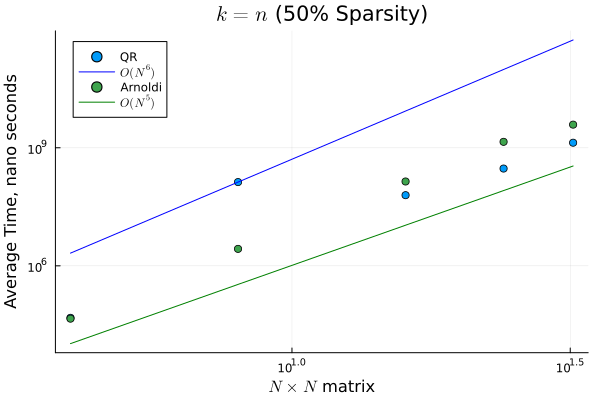

In [12]:
"##############

WARNING: CAN TAKE A FEW MINUTES TO RUN
PLOTS THE TIME COMPLEXITY OF BOTH ARNOLDI AND QR
IN CURRENT SETUP: RUNS UP TO 32×32 MATRICES WITH 50% SPARSITY
CAN EASILY BE MODIFIED TO TEST DIFFERENT ARRANGEMENTS (AS SEEN IN REPORT)

##############"

x=[4,8,16,24,32] #Dimensions of matrices to collect data for

o = []
times = []
for i in x                                           
    print("Processing ",i,"x",i)                          #Indicate progress of the function
    a = randmatrix(i,Int64(i^2/2))               #Generate random sparse matrix, set the second argument to control sparsity. i^2 being dense.
    t = @benchmark hessfrancisqralg(l) setup=(l=copy($a)) samples=10 evals=1
    push!(o,i)                                            #Fill the list with n-values for x-axis plotting
    push!(times, mean(t).time)                             #Fill the list with mean runtime of function for given n-size matrix
end

ao = []
atimes = []
for i in x                                            
    print("Processing ",i,"x",i)                          #Indicate progress of the function
    a = randmatrix(i,Int64(i^2/2))                #Generate random sparse matrix, set the second argument to control sparsity. i^2 being dense.
    t = @benchmark arnhessfrancisqralg(l) setup=(l=$a) samples=10 evals=1
    push!(ao,i)                                            #Fill the list with n-values for x-axis plotting
    push!(atimes, mean(t).time)                             #Fill the list with mean runtime of function for given n-size matrix
end

plot(o,times,xaxis=:log10,yaxis=:log10,seriestype=:scatter,label="QR")
hcomplexity =@. times[2]*o^6/o[2]^6
plot!(o,hcomplexity,linecolor=:blue,label=L"O(N^6)")
plot!(ao,atimes, seriestype=:scatter,label="Arnoldi")
acomplexity =@. atimes[2]*ao^5/ao[2]^6
plot!(ao,acomplexity,linecolor=:green,label=L"O(N^5)")
xlabel!(L"$N\times N$ matrix")
ylabel!("Average Time, nano seconds")
title!(L"$k=n$ (50% Sparsity)")
plot!(legend=:topleft)

In [13]:
"#############

GENERATES CONTOUR PLOTS
SEEMS TO BE SOME SORT OF IMPLEMENTATION ISSUE ON JUPYTER NOTEBOOK
RESUTLS OF THIS CODE ARE IN THE REPORT, BUT IT WILL NOT RUN PROPERLY HERE
A SECOND CONTOUR PLOTS FILE IS SUBMITTED WITH A .JL FILE EXTENTION

#############"

function hessfrancisqralg2(M::Matrix{Float64})
    
    #count = 0
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    ϵ1 = 1e-3 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    #Reduces matrix to hessenberg form
    newA = francisqrdecomp(M, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(M, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newA, n, ϵ1) #Makes list of eigenvalues of newA
    count = 0
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
        count += 1
        #of each other and continues iterating if they are not
        A = newA #Updates A
        newA = francisqrdecomp(A, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newA, n, ϵ1) #Updates list of eigenvalues of newA
        if count > 200
            break
        end
    end
    #println(count)
    
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end


#Plots Matrix Size v. Sparsity

#Computes Meantimes/Standard Deviation for various levels of sparsity.
meantime = []
meantimesample = []
sparsemeantime = []
standarddeviation = []
#No of Samples for a given Sparsity and Matrix Size
ksample = 1
#Maximum Matrix Size
msize = 70
#Maximum Sparsity
nsparse = 40
#Step change in Sparsity
s1 = 5
#Step change in Matrix Size
s2 = 5

meantime = []
for sizes = 1:(Int64(msize/s2))
    #Determines size of a matrix for a step/iteration in the for loop
    stepsize = s2*sizes
    #Re-initializes sparse list for each change in matrix size
    sparsemeantime = []
    for sparsity = 1:Int(nsparse/s1)
        #Re-initializes sample list for each change in sparsity
        samplemeantime = []
        for samples = 1:ksample
            #Records time taken to compute a sample
            t1 = time()
            #Computes Arnoldi Hessenberg Function with Hess Francis/QR at various levels of percentage sparsity from s1% to nsparse%
            
            #Computes Arnoldi Hessenberg Function with Hess Francis/QR for different samples at various levels of percentage sparsity from s1% to nsparse%
            #H = hessfrancisqralg2(arnoldihessenberg(randmatrix(stepsize,Int64(floor(s1*sparsity*(stepsize)/100))),normalizedrandomvector(stepsize,Int64(ceil(stepsize/2))),Int64(ceil(stepsize/2))))
            #Computes Hess Francis/QR for different samples at various levels of percentage sparsity from s1% to nsparse%
            H = hessfrancisqralg2(randmatrix(stepsize,Int64(floor(s1*sparsity*(stepsize)/100))))
            elapsed_time = time() - t1;
            #Adds recorded value to list of samples
            #Removes 0 from median scores
            if elapsed_time > 0
                push!(samplemeantime,Float64(elapsed_time/stepsize^2))
            end

        end
        #Provides the value of a pixel on the contour plot - by calculating from the samples (determined by ksample) the median time taken to compute. 
        #Adds to sparsity vector.
        #Adds a 0 if no other values record
        if samplemeantime  == []
            push!(samplemeantime,0.0)
        end
        push!(sparsemeantime,median(samplemeantime))
        #println(meantime)
    end
    #Provides the values of a line of a contour plot - All sparsities for a given Matrix Size.
    #Adds to meantime matrix.
    push!(meantime,Float64.(sparsemeantime))
end

A = meantime
#Combines All of the vectors of meantime into one singular matrix
a = []
a = Float64.(vcat(a, A[1]))
#Each Index Note
for i in 2:length(A)
    a = hcat(a,A[i])
end 
#For Logarithmic Plots
#=
loga = log.(a)
b = loga[1:10,1:20]
=#
a
#Plots subset of Matrix as Domain
#Change these values for what subset of the data you'd like to look at.
b = a[1:8,1:10]
#Produces Contour Plot
function contour4()
    z = b
    data = contour(;z=z, colorscale="Jet", connectgaps = true)
    layout = Layout(;title="Contour Plot for Sparsity v. Matrix Size - QR",xaxis=attr(title="Matrix Size"),yaxis=attr(title="Sparsity"))
    plot(data)
end
contour4()

LoadError: UndefVarError: `attr` not defined

In [13]:
"############
WARNING: CAN TAKE A LONG TIME TO RUN DEPENDING ON SET UP
TESTS COMPUTATION TIME OF ARNOLDI ALGORITHM FOR GIVEN MATRIX AND ARNOLDI BLOCK SIZES
CURRENT SETUP IS MATRIX SIZES IN RANGE 2,4,8,16,32 AND ARNOLDI BLOCK k=N
MUCH LARGE SIZES WHERE TESTED FOR PROJECT, BUT THIS MASSIVELY INCREASES RUN TIME.
CAN EASILY BE CHANGED FOR DIFFERENT DATA
THIS WAS RUN 6 TIMES TO GET SETS OF DATA, AND THEN AVERAGE OF THESE WAS PLOTTED WITH STANDARD DEVIATION INCLUDED
############"

"""
Same as arnhessfrancisqralg but allows differing arnoldi block sizes
"""
function hessfrancisqralgArn(M::Matrix{Float64},k::Int64)
    n = size(M, 1) #Calcaulates size of matrix (assumed square)
    @assert k <= n
    b = normalizedrandomvector(n,k)
    M = arnoldihessenberg(M,b,k)
    M = ComplexF64.(M) #Converts matrix into complex form
    n = size(M, 1)
    ϵ1 = 1e-5 #Error term (used to check when algorithm should terminate)
    ϵ2 = (ϵ1)^2 #Sqaure of Error term (used to avoid having to take square root of complex numbers)
    newM = francisqrdecomp(M, n, ϵ1) #Performs francis double shift QR decomposition
    Eigen = extracteigen(M, n, ϵ1) #Makes list of eigenvalues of A
    newEigen = extracteigen(newM, n, ϵ1) #Makes list of eigenvalues of newA
    while all(abs2.(Eigen-newEigen) .< ϵ2) == false #checks if the eigenvalues of the newA and A are all within ϵ1
                                                    #of each other and continues iterating if they are not
        M = newM #Updates A
        newM = francisqrdecomp(M, n, ϵ1) #Computes newA
        Eigen = newEigen #Updates list of eigenvalues of A
        newEigen = extracteigen(newM, n, ϵ1) #Updates list of eigenvalues of newA
    end
    for i in 1:n #Iterates over all eigenvalues
        if abs2(newEigen[i].im) < ϵ2 #Checks if imaginary part of eigenvalue is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].re) #If so, removes imaginary component so that the eigenvalue is real
        end
        if abs2(newEigen[i].re) < ϵ2 #Checks if real part of eigenvale is within ϵ1 of 0
            newEigen[i] = ComplexF64(newEigen[i].im) #If so, removes real component so that the eigenvalue is imaginary
        end
    end
    return newEigen #Returns eigenvalues
end


x=[2,4,8,16,32]                                            #Matrix sizes to test

times = []
for i in x                                            
    a = randmatrix(i,i^2)                                            #Generate random matrix of size i and sparsity 0%
    t = @benchmark hessfrancisqralgArn($a,$i) samples=10 evals=1     #Benchmark time of algorithm to compute across 10 interpolated samples
    push!(times, mean(t).time)                                       #Fill the list with mean runtime of function for given i-size matrix
    println("Processing ",i,"-",times)                               #Shows progress of function
end

Processing 2-Any[3125.1]
Processing 4-Any[3125.1, 35791.7]
Processing 8-Any[3125.1, 35791.7, 1.1315545e6]
Processing 16-Any[3125.1, 35791.7, 1.1315545e6, 2.332322833e8]
Processing 32-Any[3125.1, 35791.7, 1.1315545e6, 2.332322833e8, 1.7978400625e9]


In [14]:
"##############
WARNING: CAN TAKE A LONG TIME TO RUN DEPENDING ON SET UP
TESTS COMPUTATION TIME OF QR ALGORITHM FOR GIVEN MATRIX SIZES
CURRENT SETUP IS MATRIX SIZES IN RANGE 2,4,8,16,32
MUCH LARGE SIZES WHERE TESTED FOR PROJECT, BUT THIS MASSIVELY INCREASES RUN TIME.
CAN EASILY BE CHANGED FOR DIFFERENT DATA
THIS WAS RUN 6 TIMES TO GET SETS OF DATA, AND THEN AVERAGE OF THESE WAS PLOTTED WITH STANDARD DEVIATION INCLUDED
##############"
x=[2,4,8,16,32]                                      #Matrix sizes to test

times = []
for i in x                                                   
    a = randmatrix(i,i^2)                                    #Generate random matrix of size i and sparsity 0%
    t = @benchmark hessfrancisqralg($a) samples=10 evals=1   #Benchmark time of algorithm to compute across 10 interpolated samples
    push!(times, mean(t).time)                               #Fill the list with mean runtime of function for given i-size matrix
    println("Processing ",i,"-",times)                       #Shows progress of function
end
     

Processing 2-Any[2158.2]
Processing 4-Any[2158.2, 28058.5]
Processing 8-Any[2158.2, 28058.5, 1.01583625e7]
Processing 16-Any[2158.2, 28058.5, 1.01583625e7, 4.79792248e7]
Processing 32-Any[2158.2, 28058.5, 1.01583625e7, 4.79792248e7, 1.4169070693333333e9]


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(log10(Y)) ~ 1 + :(log10(X))

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  2.30617    0.266767   8.64    0.0001    1.65341    2.95893
log10(X)     5.23445    0.189415  27.63    <1e-06    4.77096    5.69793
───────────────────────────────────────────────────────────────────────StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(log10(Y)) ~ 1 + :(log10(X))

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)

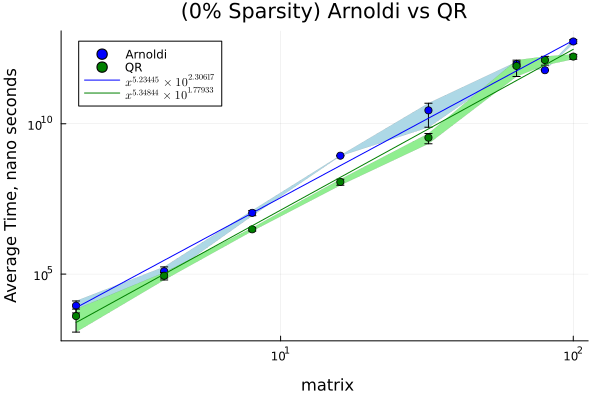

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [16]:
"##########
MAKES PLOT OF ARNOLDI VS QR COMPUTATION TIME FOR MATRICES OF SIZE 2 TO 100 AND ALL ELEMENTS NON ZERO
USES RECORDED DATA FOR EACH ALGORITHM ON EACH SIZE AFTER 6 BENCHMARK TESTS
CAN BE MODIFIED TO VARY MATRIX AND ARNOLDI BLOCK SIZES, ALTHOUGH NEW DATA WOULD NEED TO BE INPUTTED TO REALISE THIS
##########"

#Matrix sizes
msize=[2,4,8,16,32,64,80,100]

#Arnoldi computational times
timesa1=[7670.0, 270370.0, 4.56498e6, 8.845209e8, 1.262998136e11, 2.2494530575e12, 8.13452993e10, 3.5966422346e12]
timesa2=[6050.0, 87920.0, 708620.0, 1.73361585e9, 1.21490856e10, 7.44053277e10, 5.313302287e11, 1.2074416092e12]
timesa3=[6990.0, 70070.0, 1.097951e7, 3.474861e7, 5.5271172e9, 9.40631805e10, 1.84159339e11, 2.4507259399e12]
timesa4=[4880.0, 112220.0, 9.93537e6, 1.2396017e8, 7.4891421e9, 5.369891267e11, 1.414884314e11, 4.6643845259e12]
timesa5=[9110.0, 118100.0, 3.626836e7, 3.8416683e8, 1.04685558e10, 2.421986993e11, 1.5467491548e12, 1.40936389869e13]
timesa6=[18900.0, 84610.0, 2.94791e6, 2.04170455e9, 5.768634e9, 2.6042987103e12, 1.1440542895e12, 6.742654998e12]
avgtimesa=(timesa1.+timesa2.+timesa3.+timesa4.+timesa5.+timesa6)/6

#Standard Deviation of times for each matrix for Arnoldi algorithm
errorsa=[]
for i in 1:8
    sd = std([timesa1[i],timesa2[i],timesa3[i],timesa4[i],timesa5[i],timesa6[i]])
    push!(errorsa, sd)
end
errosa = abs.(errorsa.-avgtimesa)

#QR computational times
timesq1=[ 4200.0, 104800.0, 2.09343e6, 2.1857653e8, 1.01326375e9, 3.4239438084e12, 4.889480314e11, 5.915932645e11]
timesq2=[ 3600.0, 56410.0, 1.5605e6, 1.2022242e8, 2.7129456e9, 2.012208786e11, 1.3477929654e12, 1.5151911558e12]
timesq3=[2190.0, 50250.0, 2.14095e6, 7.695913e7, 8.5871254e8, 1.239470999e11, 8.7629105e10, 2.6648696294e12]
timesq4=[3540.0, 46040.0, 650170.0, 2.76135e7, 8.43428575e8, 1.688407235e11, 8.643118977e11, 4.0773887544e12]
timesq5=[5430.0, 211230.0, 3.90829e6, 2.650898e7, 2.3014849e9, 1.854312207e11, 4.7635021839e12, 9.942812042e11]
timesq6=[5100.0, 61550.0, 8.13554e6, 2.2840658e8, 1.30244614e10, 9.233220663e11, 3.499512663e11, 4.659113556e11]
avgtimesq=(timesq1.+timesq2.+timesq3.+timesq4.+timesq5.+timesq6)/6

#Standard Deviation of times for each matrix for QR algorithm
errorsq=[]
for i in 1:8
    sd = std([timesq1[i],timesq2[i],timesq3[i],timesq4[i],timesq5[i],timesq6[i]])
    push!(errorsq, sd)  
end
errosq = abs.(errorsq.-avgtimesq)


# Arnoldi Line of Best Fit
data = DataFrame(X=msize, Y=avgtimesa)
print(lm(@formula(log10(Y)~log10(X)), data))

# QR Line of Best Fit
data = DataFrame(X=msize, Y=avgtimesq)
print(lm(@formula(log10(Y)~log10(X)), data))
     


########Makes Plot#######

#Lines of best fit (record from above output)
a = (msize.^5.23445).*10^2.30617
q = (msize.^5.34844).*10^1.77933

ys, xs = [avgtimesa - errosa; reverse(avgtimesa + errosa)], [msize; reverse(msize)]
plot(xs, ys, st=:shape, fc=:blues, lw=0, label=false)

ys, xs = [avgtimesq - errosq; reverse(avgtimesq + errosq)], [msize; reverse(msize)]
plot!(xs, ys, st=:shape, fc=:lightgreen, lw=0, label=false)

plot!(msize,avgtimesa,xaxis=:log10,yaxis=:log10,seriestype=:scatter,color=:blue,yerror=errosa,label="Arnoldi")


plot!(msize,avgtimesq,xaxis=:log10,yaxis=:log10,seriestype=:scatter,color=:green,yerror=errosq,label="QR")
plot!(msize, a, linecolor=:blue, label=L"x^{5.23445}\times 10^{2.30617}")
plot!(msize,q, linecolor=:green,label=L"x^{5.34844}\times 10^{1.77933}")

xlabel!(L"
 matrix")
ylabel!("Average Time, nano seconds")
title!("(0% Sparsity) Arnoldi vs QR")
plot!(legend=:topleft)